In [1]:
from networks import *
from datasets import PixelDataset
import utils as ut
import matplotlib.pyplot as plt  
import os 

%reload_ext autoreload

In [2]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")


Using device: mps


In [3]:
FOX_IMG_PATH = "./data/images/fox.jpg"
dataset = PixelDataset(FOX_IMG_PATH)
fox_img = ut.read_img(FOX_IMG_PATH)
dataset.coords.shape

torch.Size([705536, 2])

In [4]:
REMI_PARIS_PATH = "./data/images/remi_paris.jpg"
dataset_remi_paris = PixelDataset(REMI_PARIS_PATH)
remi_paris_img = ut.read_img(REMI_PARIS_PATH)

In [5]:
iteration_benchmarks = set([100, 250, 500, 1000, 2000, 3000])

def get_dataloader(dataset, batch_size, shuffle=False, num_workers=4):
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers 
    )

def train(model, dataset, dataloader_train, dataloader_test, params, plot_psnr=False):
    # Train Loop
    model.train()
    iterations = 0
    done = False

    num_iterations = params["iter"]

    # Defining Criterion: We use PSNR (Peak Signal to Noise Ratio). This is a modified MSE loss that is computed in the training loop.
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=params["lr"])

    iteration_history = []
    psnr_history = []
    
    while not done:
        for coords, pixels in dataloader_train:
            
            coords = coords.to(device)
    
            # (batch_size, 3)
            pixels = pixels.to(device)
    
            # (batch_size, 3)
            predicted_pixels = model(coords)
    
    
            # PSNR Loss. Note we are minimizing -PSNR => maximizing PSNR
            loss = criterion(predicted_pixels, pixels)
            psnr = 10 * torch.log10(1.0 / criterion(predicted_pixels, pixels))
            

            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            iterations += 1
        
            if iterations % 100 == 0:
                print(f"Iteration [{iterations}/{num_iterations}], Loss: {loss.item():.6f}")

            if iterations in iteration_benchmarks:
                # Evaluate and save image
                params["iter"] = iterations
                eval_model(model, dataset, dataloader_test, params)
                model.train()

            psnr_val = psnr.item()
            iteration_history.append(iterations)
            psnr_history.append(psnr_val)
                
            if iterations >= num_iterations:
                done = True

    if plot_psnr:
        print("Plotting PSNR curve...")
        plt.figure(figsize=(10, 5))
        plt.plot(iteration_history, psnr_history)
        plt.title(f"PSNR vs. Iterations ({params['name']})")
        plt.xlabel("Iteration")
        plt.ylabel("PSNR (dB)")
        plt.grid(True)
        plt.savefig(f"./results/{params['name']}_psnr_curve.png")
        print(f"PSNR curve saved to ./results/{params['name']}_psnr_curve.png")
        # plt.show() # Uncomment this if you are in a notebook and want to see it
    
    print("Training finished!")

def eval_model(model, dataset, dataloader, params, out_path="./results"):
    # Evaluation Loop
    model.eval()
    dataloader_eval = dataloader
    
    all_predicted_pixels = []
    with torch.no_grad():
        for coords, _ in dataloader_eval:
            coords = coords.to(device)
    
            predicted_pixels = model(coords).cpu().detach()
            all_predicted_pixels.append(predicted_pixels)
    
    # Concatenate into (H*W, 3)
    all_predicted_pixels = torch.cat(all_predicted_pixels, dim=0)
    H, W = dataset.height, dataset.width
    reconstructed_img_tensor = all_predicted_pixels.reshape(H, W, 3)
    reconstructed_img = reconstructed_img_tensor.cpu().numpy()
    ut.save_img(reconstructed_img, f"{out_path}/{params["name"]}_n_layers={params["n_layers"]}_width={params["width"]}_L={params["L"]}_iter={params["iter"]}_lr={params["lr"]}.jpg")


In [9]:
batch_size = 10000
fox_mlp_default_params = {
    "name" : "fox_default",
    "n_layers" : 3,
    "width" : 256,
    "L" : 10,
    "lr" : 1e-2,
    "batch_size" : batch_size,
    "iter" : 3000
}
fox_mlp_default = MLP(fox_mlp_default_params).to(device) 


# Result 1
fox_mlp_larger_params = {
    "name" : "fox_larger",
    "n_layers" : 8,
    "width" : 512,
    "L" : 10,
    "lr" : 1e-3,
    "batch_size" : batch_size,
    "iter" : 3000
}
fox_mlp_larger = MLP(fox_mlp_larger_params).to(device)

# Result 2
fox_mlp_small_L_params = {
    "name" : "fox_larger",
    "n_layers" : 8,
    "width" : 512,
    "L" : 2,
    "lr" : 1e-3,
    "batch_size" : batch_size,
    "iter" : 3000
}
fox_mlp_small_L = MLP(fox_mlp_small_L_params).to(device)

# Result 3
fox_mlp_small_width_params = {
    "name" : "fox_larger",
    "n_layers" : 8,
    "width" : 64,
    "L" : 10,
    "lr" : 1e-3,
    "batch_size" : batch_size,
    "iter" : 3000
}
fox_mlp_small_width = MLP(fox_mlp_small_width_params).to(device)



# Result 4
fox_mlp_small_params = {
    "name" : "fox_larger",
    "n_layers" : 8,
    "width" : 64,
    "L" : 2,
    "lr" : 1e-3,
    "batch_size" : batch_size,
    "iter" : 3000
}
fox_mlp_small = MLP(fox_mlp_small_params).to(device)









Encoder Dim: 42
Encoder Dim: 42
Encoder Dim: 10
Encoder Dim: 42
Encoder Dim: 10


In [8]:
batch_size = 10000

remi_paris_mlp_default_params = {
    "name" : "remi_paris_larger",
    "n_layers" : 8,
    "width" : 512,
    "L" : 10,
    "lr" : 1e-3,
    "batch_size" : batch_size,
    "iter" : 3000
}

remi_paris_mlp_larger_params = {
    "name" : "remi_paris_larger",
    "n_layers" : 8,
    "width" : 512,
    "L" : 10,
    "lr" : 1e-3,
    "batch_size" : batch_size,
    "iter" : 3000
}
remi_paris_mlp_larger = MLP(remi_paris_mlp_larger_params).to(device)
remi_paris_mlp_default = MLP(remi_paris_mlp_default_params).to(device)

Encoder Dim: 42
Encoder Dim: 42


Iteration [100/3000], Loss: 0.026952
Reconstructed image saved as ./results/fox_larger_n_layers=8_width=512_L=2_iter=100_lr=0.001.jpg
Iteration [200/3000], Loss: 0.019556
Reconstructed image saved as ./results/fox_larger_n_layers=8_width=512_L=2_iter=250_lr=0.001.jpg
Iteration [300/3000], Loss: 0.016957
Iteration [400/3000], Loss: 0.010759
Iteration [500/3000], Loss: 0.009554
Reconstructed image saved as ./results/fox_larger_n_layers=8_width=512_L=2_iter=500_lr=0.001.jpg
Iteration [600/3000], Loss: 0.008606
Iteration [700/3000], Loss: 0.006286
Iteration [800/3000], Loss: 0.010438
Iteration [900/3000], Loss: 0.006523
Iteration [1000/3000], Loss: 0.006753
Reconstructed image saved as ./results/fox_larger_n_layers=8_width=512_L=2_iter=1000_lr=0.001.jpg
Iteration [1100/3000], Loss: 0.004969
Iteration [1200/3000], Loss: 0.004983
Iteration [1300/3000], Loss: 0.004814
Iteration [1400/3000], Loss: 0.004678
Iteration [1500/3000], Loss: 0.004479
Iteration [1600/3000], Loss: 0.004113
Iteration [1

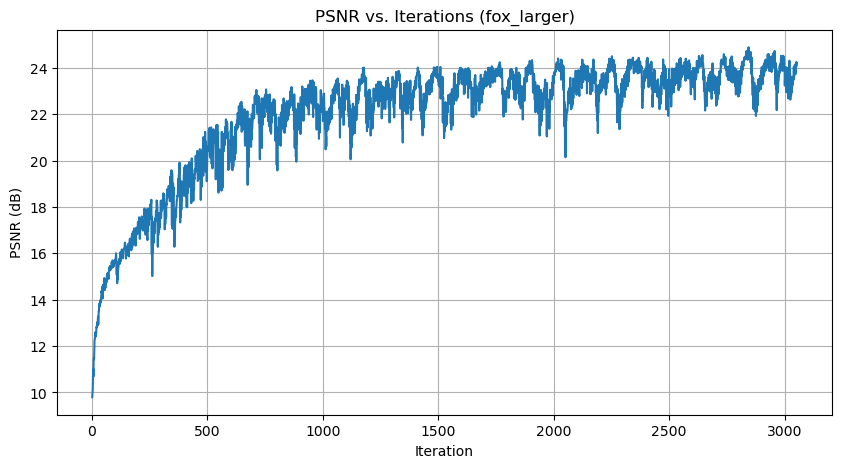

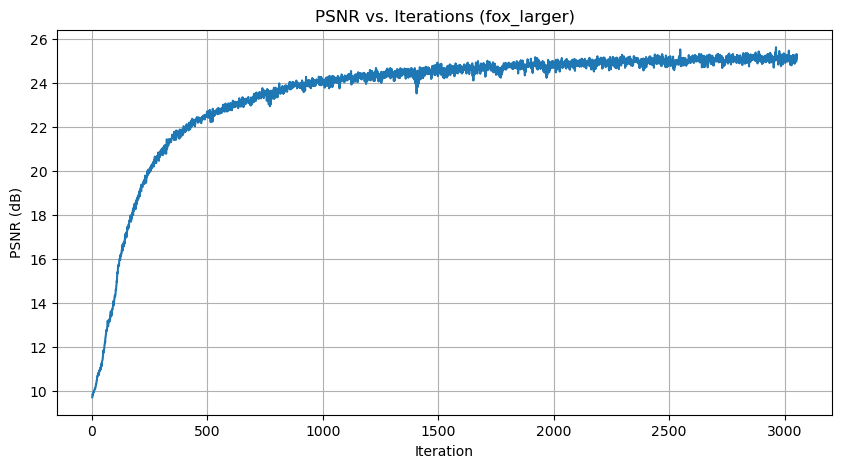

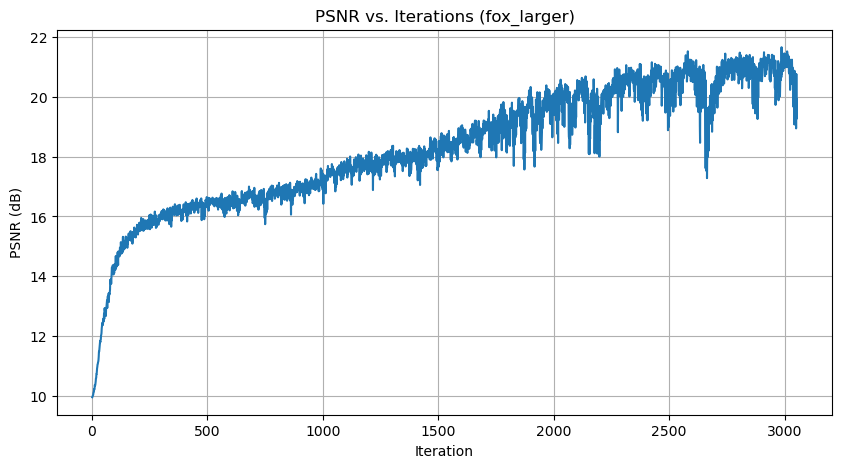

In [12]:
train_loader = get_dataloader(dataset, batch_size, shuffle=True, num_workers=4)
test_loader = get_dataloader(dataset, batch_size, shuffle=False, num_workers=4)

#train(fox_mlp_default, train_loader, test_loader, fox_mlp_default_params)
#train(fox_mlp_larger, train_loader, test_loader, fox_mlp_larger_params)

# Varying L and width (Results 2, 3, 4)
train(fox_mlp_small_L,dataset, train_loader, test_loader, fox_mlp_small_L_params, plot_psnr=True)
train(fox_mlp_small_width, dataset, train_loader, test_loader, fox_mlp_small_width_params, plot_psnr=True)
train(fox_mlp_small, dataset, train_loader, test_loader, fox_mlp_small_params, plot_psnr=True)




Iteration [100/3000], Loss: 0.009315
Reconstructed image saved as ./results/remi_paris_larger_n_layers=8_width=512_L=10_iter=100_lr=0.001.jpg
Iteration [200/3000], Loss: 0.004251
Reconstructed image saved as ./results/remi_paris_larger_n_layers=8_width=512_L=10_iter=250_lr=0.001.jpg
Iteration [300/3000], Loss: 0.003035
Iteration [400/3000], Loss: 0.002635
Iteration [500/3000], Loss: 0.002242
Reconstructed image saved as ./results/remi_paris_larger_n_layers=8_width=512_L=10_iter=500_lr=0.001.jpg
Iteration [600/3000], Loss: 0.001990
Iteration [700/3000], Loss: 0.001945
Iteration [800/3000], Loss: 0.001562
Iteration [900/3000], Loss: 0.001629
Iteration [1000/3000], Loss: 0.001547
Reconstructed image saved as ./results/remi_paris_larger_n_layers=8_width=512_L=10_iter=1000_lr=0.001.jpg
Iteration [1100/3000], Loss: 0.001564
Iteration [1200/3000], Loss: 0.001459
Iteration [1300/3000], Loss: 0.001413
Iteration [1400/3000], Loss: 0.001342
Iteration [1500/3000], Loss: 0.001303
Iteration [1600/30

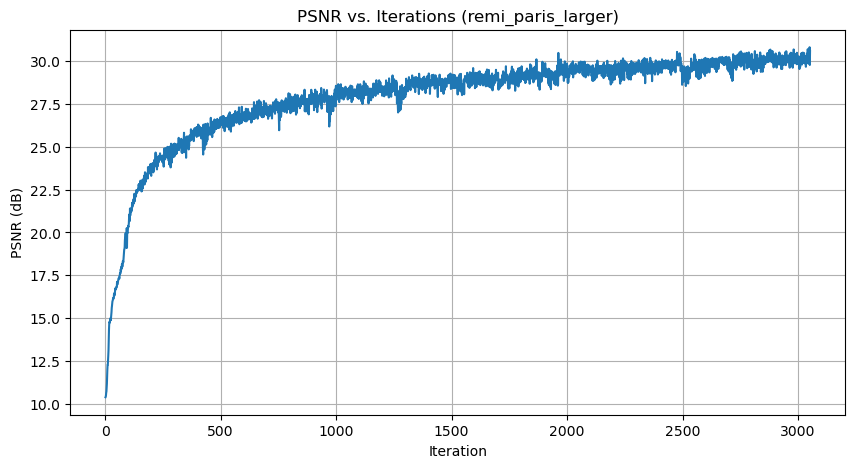

In [ ]:
train_loader = get_dataloader(dataset_remi_paris, batch_size, shuffle=True, num_workers=4)
test_loader = get_dataloader(dataset_remi_paris, batch_size, shuffle=False, num_workers=4)

#train(fox_mlp_default, train_loader, test_loader, fox_mlp_default_params)
#train(remi_paris_mlp_larger, dataset_remi_paris, train_loader, test_loader, remi_paris_mlp_larger_params, plot_psnr=True)

